<a href="https://colab.research.google.com/github/Kalbar1234/PRA3024/blob/main/Kopia_notatnika_ML_cifar_CNN_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys

if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')
    
    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)
    
        

    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)
    

def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):
    
    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]
    
    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)
    
    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')
    
    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])

    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [2]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.3


In [3]:
# Load the data samples

x_train, y_train, x_val, y_val, x_test, y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


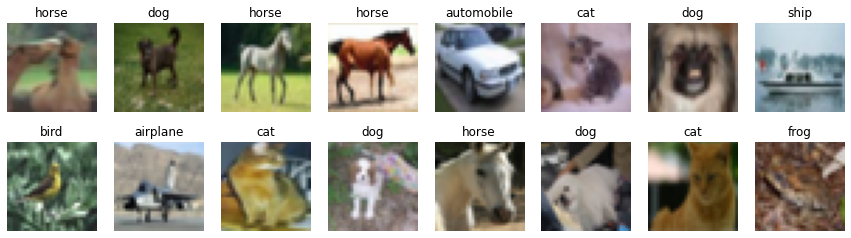

In [4]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [5]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

In [6]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Activation, Dropout, concatenate, BatchNormalization, Add, GlobalAveragePooling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.regularizers import l2

In [ ]:
# FAILED MODEL - not efficient enough

# def identity(x, n_filters):
  
#   conv3 = Conv2D(n_filters, (1, 1), activation='relu', padding='same')(x)
#   conv3 = BatchNormalization()(conv3)

#   conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
#   conv3 = BatchNormalization()(conv3)
  
#   conv3 = Conv2D(n_filters, (1, 1), activation='relu', padding='same')(conv3)
#   conv3 = BatchNormalization()(conv3)

#   output = Add()([x,conv3])
#   output = Activation('relu')(output)

#   return output

In [ ]:
# FAILED MODEL - not efficient enough

# def conv_block(x, n_filters):
#   conv1 = Conv2D(n_filters, (1, 1), activation='relu', padding='same')(x)
#   conv1 = BatchNormalization()(conv1)

#   conv3 = Conv2D(n_filters, (1, 1), activation='relu', padding='same')(x)
#   conv3 = BatchNormalization()(conv3)
#   conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)
#   conv3 = BatchNormalization()(conv3)
#   conv3 = Conv2D(n_filters, (1, 1), activation='relu', padding='same')(conv3)
#   conv3 = BatchNormalization()(conv3)

#   output = Add()([conv1,conv3])
#   output = Activation('relu')(output)

#   return output
  

In [ ]:
# FAILED MODEL - not efficient enough

# def inception_block2(x, n_filters):
  
#   conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
#   conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)
#   conv5a = Conv2D(n_filters, (1, 3), activation='relu', padding='same')(conv5)
#   conv5b = Conv2D(n_filters, (3, 1), activation='relu', padding='same')(conv5)

#   conv3 = Conv2D(n_filters, (1, 1), activation='relu', padding='same')(x)
#   conv3a = Conv2D(n_filters, (3, 1), activation='relu', padding='same')(conv3)
#   conv3b = Conv2D(n_filters, (1, 3), activation='relu', padding='same')(conv3)

#   conv1 = Conv2D(n_filters, (1, 1), activation='relu', padding='same')(x)

#   maxpool = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(x)
#   maxpool = Conv2D(n_filters, (1, 1), activation='relu', padding='same')(maxpool)

#   output = concatenate([conv5a,conv5b,conv3a,conv3b,conv1,maxpool])
  

#   return output

In [ ]:
# FAILED MODEL - not efficient enough

# def inception_block(x, n_filters):
  
#   conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(x)
#   conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)
#   conv5 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv5)

#   conv3 = Conv2D(n_filters, (1, 1), activation='relu', padding='same')(x)
#   conv3 = Conv2D(n_filters, (3, 3), activation='relu', padding='same')(conv3)

#   conv1 = Conv2D(n_filters, (1, 1), activation='relu', padding='same')(x)

#   maxpool = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(x)
#   maxpool = Conv2D(n_filters, (1, 1), activation='relu', padding='same')(maxpool)

#   output = concatenate([conv5,conv3,conv1,maxpool])

#   return output

In [ ]:
# FAILED MODEL - not efficient enough

# image_size = [32,32]

# def make_model():
#   inputs = tf.keras.Input(shape=(32,32,3))  
  
#   x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
#   x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#   x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
#   x = BatchNormalization()(x)
#   x = MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same')(x)


#   x = identity(x,128)
#   x = identity(x,128)
#   x = identity(x,128)
#   x = identity(x,128)

#   x = identity(x,128)
#   x = identity(x,128)
#   x = identity(x,128)
#   x = identity(x,128)

#   x = GlobalAveragePooling2D()(x)
#   x = Flatten()(x)

#   x = Dense(256, activation='relu')(x)
#   x = BatchNormalization()(x)
  
#   outputs = Dense(NUM_CLASSES, activation='softmax')(x)

#   model = keras.Model(inputs=inputs, outputs=outputs)

#   return model

In [13]:
image_size = [32,32]

def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    ### STUDENT CODE HERE ###

    model = Sequential()

    # 1st Convolutional block - extracting inital features & input layer
    model.add(Conv2D(48, (3, 3), activation='relu', padding='same', input_shape=(*image_size,3)))
    model.add(Conv2D(48, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
    model.add(Dropout(0.1))

    # 2nd Convolutional block
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
    model.add(Dropout(0.2))

    # 3rd Convolutional block
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())

    model.add(AveragePooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
    model.add(Dropout(0.3))


    # Flattening the shape so the Dense layer can proceed the tensors
    model.add(Flatten())

    # 2 hidden Dense layers 
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(NUM_CLASSES,activation='softmax'))


    ### END STUDENT CODE ### 

    return model

In [15]:
# create data augmentions
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1)

Learning rate schedule: 1e-05 to 4.2e-05 to 2.7e-12


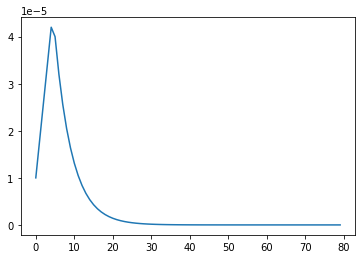

In [9]:
LR_START = 0.00001
LR_MAX = 0.00005 
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8
EPOCHS = 80

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) 
    return lr

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [10]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode="auto", restore_best_weights=True)
lr_callback = LearningRateScheduler(lrfn, verbose=True)

callback_list = [callback, lr_callback]

In [14]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training


BATCH_SIZE = 32
EPOCHS = 80


K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

model.summary()

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.Adam(),  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)

datagen.fit(x_train)


# fit model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
    callbacks = callback_list)

# save weights to file to avoid re-training
model.save_weights("weights.h5")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 48)        1344      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 48)        20784     
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 48)        192       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 48)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        27712     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        3

In [16]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

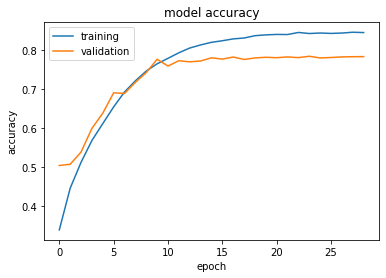

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


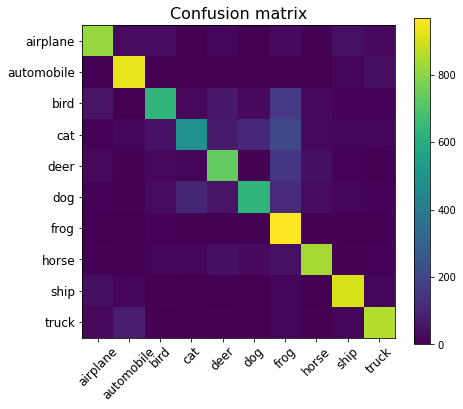

Test accuracy: 0.7802


In [18]:
# make test predictions
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test_index, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

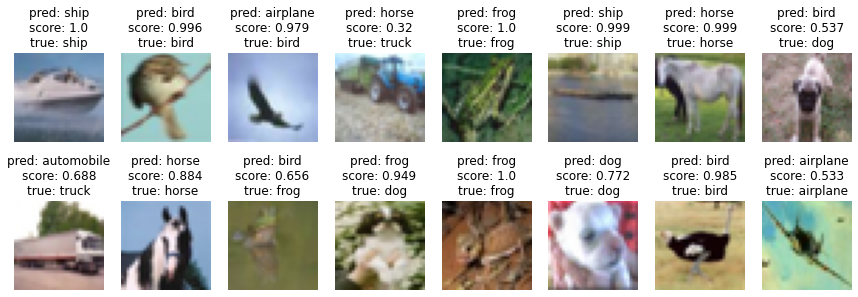

In [19]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons, 
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.




In [ ]:
# REPORT

# Main architecture=============================================================

# For the baseline network many different architectures were tested: AlexNet, VGG-16, Inception-v1, ResNet-50, a custom basic CNN and a mix between
# VGG-16 and Inception-v1. Most of the different architectures took up to 3 minutes to train per epoch (on google collab GPUs) and gave an val_acc 
# of about 70 %. Most of them also converged to a specific value after 10-15 epochs.
# *I left the different model commented out together with the functions that I used specifically for them as proof that I tried them*

# The most effective proved to be the VGG-16 architecture which is a simple CNN combined out of 6 different blocks: 2 blocks of 2x Conv 3x3 and 
# Max Pool, 3 blocks of 3 Conv 3x3 and Max Pool and a block of 2 dense layers with the output dense layer. 
# For the CIFAR-10 dataset the architecture had to be trimmed down to only 1 initial conv block and 2 middle conv layers. 
# The reason for using fewer layers was mainly the small resolution of the images. After 3 pool layers, the resolution goes down to 4x4 or 
# 16 pixel in total from 32x32 or 1024 pixels in total. The high number of filters in the conv layer allows for more feature extraction which 
# can help identify different objects. An increasing amount of filters also proofed to be more effective than a static amount of filters 
# through the different conv blocks. 

# Dropout layer was used after each block to limit or prevent overfitting. The value for each dropout layer increases as the network goes deeper. High 
# values below 50% turned out to be damaging to the accuracy as they result in a gap (more than 10% difference) between accuracy and valid accuracy with 
# latter having a higher value. 

# Batch Normalization allowed for more swift training time and was used after every block. 
# A double Dense layer with a high number of neurons resulted in the best val_acc however different configurations were tested like 16x16, 64x64, 1024x512 etc. 



# Callbacks & Learning Rate=====================================================

# Early stopping was implemented to prevent training the model while it already converged to a certain value and restore the best possible weights for 
# val_acc. A custom learning rate was also implemented via the callback function which allowed to modify the learning depending on the epoch number. 
# The custom learning rate curve was not fitted specifically for this problem however those values prooved to be quite useful in a different
# image classification problem that I tried to solve (function and implementation credit: DimitreOliveira on Kaggle)


# Data augmention===============================================================

# A basic set of augmentation was implemented via Image Data Generator: a slight image height, width and zoom adjustment



# What could have been improve on?==============================================

# Most of the time was used to find the best baseline model which proved to be the wrong strategy for only one week of testing.
# Because of that less time could have been allocated to tweaking the current baseline model and trying out different modifications.

# Model ensembling with a k-fold data split could have been a great way of eliminating the (small) effect of randomness involved 
# in the training. With less variance (ensemblence of different models) and more of the available (more data = more features 
# and images to train on), the overall accuracy could have been improved even further and mitigate different accuracy scores after
# each training. 

# Depedning on the labelling quality a different loss function could have been used, for example, if some of the images were labelled
# not correctly label smoothing could have been implemented which would result in a less strict loss function (lower penalty) however
# an extensive EDA would have to be performed to confirm the quality of the labels (or a quick google search...)

# Tanh or leaky relu activation functions could have been tested. 

